In [100]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [355]:
from graphviz import Digraph
from IPython.display import display, SVG


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [356]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

    def __neg__(self):  # -self
        return self * -1

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __rtruediv__(self, other):  # other / self
        return other * self ** -1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [375]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# X1*W1 + X2*W2 + b
x1w1 = x1 * w1;
x1w1.label = 'x1*w1'
x2w2 = x2 * w2;
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b;
n.label = 'n'
o = n.tanh()


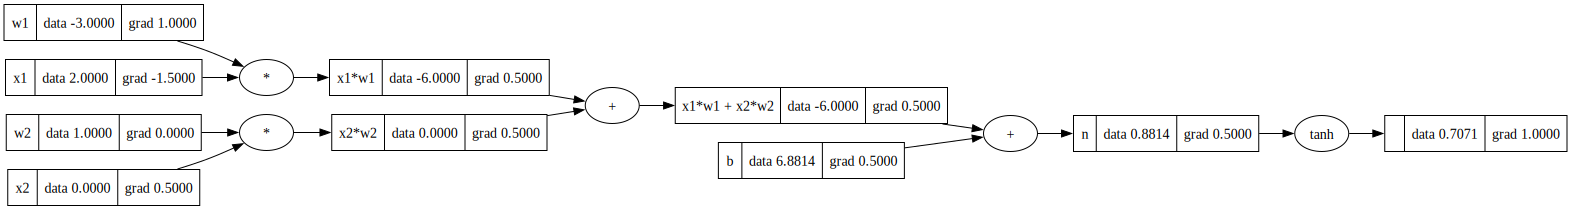

In [358]:
o.grad = 1.0
o.backward()
draw_dot(o)

In [359]:
import torch

In [360]:
x1 = torch.Tensor([2.0]).double();
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [389]:
class Neuron:
    def __init__(self, nin):  # 神经元  nin 输入维度
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)  # act 是 Value 类型
        out = act.tanh()
        return out  # out 单个输出   是 Value 类型
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):  #  nin   单个神经元输入维度    nout 神经元个数
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):  # x 维度与nin想等  全连接？
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  # nout 输出   元素是 Value 类型


    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):  #  nin输入维度    nouts 是个列表 值是每层的神经元个数
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [390]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8658288569008906, grad=0.0)

 损失函数 权重更新的引入

In [391]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets




In [392]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad  # 0.1 是学习率

  print(k, loss.data)


0 6.927353084819546
1 6.079063119128174
2 4.467685680894007
3 3.259389691637474
4 2.45345585073904
5 1.7653696008316149
6 1.4366634185458027
7 0.6504329492465003
8 0.1327515569432318
9 0.07654445589859776
10 0.059635032320891346
11 0.04940234683957066
12 0.04224832790696905
13 0.03690106377211054
14 0.03273715378728206
15 0.029399362354203845
16 0.026663758681957982
17 0.02438144379907757
18 0.02244909003241814
19 0.020792586675356512


In [372]:
""

In [397]:
nin = 3
nouts = [4, 4, 4,1]

sz = [nin] + nouts
for i in range(len(nouts)):
    print(i)
    print(i!=len(nouts)-1)

0
True
1
True
2
True
3
False
